In [1]:
import pandas as pd
import gmaps
import getpass
import metnoRequests as metno
from encrypt import decryptCredentials,decryptString
import LangtjernWeather as lw
import os
import shutil
import matplotlib
import pickle
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests
import re
from urllib.parse import urljoin
from subprocess import Popen, PIPE, CalledProcessError
import platform
import time
from IPython.display import clear_output, display
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from patsy import dmatrices
import fileinput
import instantiationFimex as fimex
import instantiationBasin as basin
from psycopg2 import sql
from parse import parse
from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union


def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
        
options = {'stdout': PIPE, 'stderr': PIPE, 'bufsize' : 1, 'universal_newlines' : True, 'shell' : False}
if (platform.system() == 'Windows'):
    options['shell'] = True
    #Packages required to generate ssh keys in windows
    from cryptography.hazmat.primitives import serialization as crypto_serialization
    from cryptography.hazmat.primitives.asymmetric import rsa
    from cryptography.hazmat.backends import default_backend as crypto_default_backend

def callPopen(cmd,verbose=True,overwrite=False):
    with Popen(cmd.split(),**options) as p:
        if verbose and not overwrite:
            for line in p.stdout:
                print(line, end='')
        if verbose and overwrite:
            for line in p.stdout:
                clear_output(wait=True)
                display(line)
        for line in p.stderr:
            print(line, end='')
        if p.returncode != (0 or None):
            raise CalledProcessError(p.returncode, p.args)


def isInstance(name):
    instanceExists=False
    ip=''
    with Popen('gcloud compute instances list'.split(),**options) as p:
        for line in p.stdout:
            if re.match('^{}'.format(name), line):
                instanceExists=True
                ip = line.strip().split()
                ip = ip[4]
        for line in p.stderr:
            print(line, end='')
        if p.returncode != (0 or None):
            raise CalledProcessError(p.returncode, p.args)
        return(instanceExists,ip)
    
            
def text_prepender(filename, text):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(text.rstrip('\r\n') + content)

def replace(file,pattern,replace):
    fileinput.close()
    for line in fileinput.input(file, inplace=True):
        print( re.sub(pattern,
                      replace,
                      line.rstrip()
                      ) 
             )
        
if (platform.system() == 'Windows'):
    def generateSSHKey(username,savePath):
        key = rsa.generate_private_key(
            backend=crypto_default_backend(),
            public_exponent=65537,
            key_size=2048
            )
        private_key = key.private_bytes(
            crypto_serialization.Encoding.PEM,
            crypto_serialization.PrivateFormat.TraditionalOpenSSL,
            crypto_serialization.NoEncryption()
            )
        public_key = key.public_key().public_bytes(
            crypto_serialization.Encoding.OpenSSH,
            crypto_serialization.PublicFormat.OpenSSH
            )
        public_file = os.path.join(savePath,username + '.pub')
        private_file = os.path.join(savePath,username)
        text_file = open(public_file, "w")
        text_file.write(public_key.decode('utf-8') + ' ' + username)
        text_file.close()
        text_file = open(private_file, "w")
        text_file.write(private_key.decode('utf-8'))
        text_file.close()
        print('Successfully created key pair')
            
if (platform.system() == 'Linux'):
    def generateSSHKey(username,savePath):
        p = Popen("echo 'yes' | ssh-keygen -t rsa -f {0}/{1} -C {1} -N '' ".format(savePath,username),
              stdout=PIPE,
              shell=True,
              stderr=PIPE
               )
        print(p.communicate())   

## Credentials

In [2]:
#Setting up credentials for database access. These should have been previously encrypted
token = b'gAAAAABayyyn8ZnEstm8ZQqClUYQ-IqFFuMO4QTbmFJADHWBAcirh52s5stDwSwtVK7qVm5tzdTNFxTQjuRF28b1t2rosFSl_nnTowWrD4itOjkzF7s6Kg_qa1Adqpj59OAfBapgkToUQUHvEFY1Njc4he36AC76gmb8t0CJCq4ze2pDHWIlGdDacZxQ1jq14uLVxrFfCTSxDPX8Mx9W1av723etkOdWvw=='
key = getpass.getpass('Password: ')
credentials = decryptCredentials(token,key)
#credentials['host'] = basinGenerator.ip #This is because we don't have a static address for the host. A static address is provided if one uses catchment.niva.no

#Setting up credentials for google maps api access
apiToken = b'gAAAAABaXyLsGnF3ms4sC3ZhoLCwWAx9q0tydWl8XKEwOy8CO0W6Eqc8J4om8HNDlNR9nExYCmSrelp8W5R-PLtcce1I2UgW3YnlXXqWvrMN-outYwXhZoc59djfF752mzOPqXBHgpNC'
apiKey = decryptString(apiToken,key)
gmaps.configure(api_key=apiKey)

metnoToken = b'gAAAAABaYEqld0O48m09jEyMUBFTdBmZA2BVey2r7FKbo_7zrJPOa1aEGcpW0WmnhGVJHYUPm32f8ttaiboXxAF-Q9hDat3lhsa4ELzrT6J_e402kRDmWi6k0kpldOC2LTBNM9vNLLF4'
metnoKey = decryptString(metnoToken, key)
metno.init(metnoKey,'https://frost.met.no')

Password:  ·······


## Station locations and basins
### Instantiating VM to process basins


In [3]:
instance = 'oka-basin'
username = 'jose-luis'
keyDir = 'oka-basin'
region = 'europe-west3-a'
machineType = 'n1-standard-2'

basinGenerator = basin.basin(instance,username,region,keyDir,machineType,credentials=credentials)
basinGenerator.instantiate()
print("The ip of the google cloud instance is {}".format(basinGenerator.ip))

#Testing connection to instance
time.sleep(2) #Giving time for the editing to work
if basinGenerator.instanceExists:
    p = Popen("ssh -i {0}/{1} {1}@{2} -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no".format(
            basinGenerator.keyDir,
            basinGenerator.username,
            basinGenerator.ip
            ),
            shell=True,stdout=PIPE,stdin=PIPE)
    print(p.communicate())

time.sleep(2)

credentials['host'] = basinGenerator.ip

The ip of the google cloud instance is 35.198.159.165
(b'Linux oka-basin 4.9.0-6-amd64 #1 SMP Debian 4.9.88-1+deb9u1 (2018-05-07) x86_64\n\nThe programs included with the Debian GNU/Linux system are free software;\nthe exact distribution terms for each program are described in the\nindividual files in /usr/share/doc/*/copyright.\n\nDebian GNU/Linux comes with ABSOLUTELY NO WARRANTY, to the extent\npermitted by applicable law.\n', None)


In [4]:
schema = 'oka'
results = 'results'
basinGenerator.setFabfile('fabfile_catchment.py')
basinGenerator.generateBasins('stations.yaml',schema, results)

'Disconnecting from 35.198.159.165... done.\n'

/home/jose-luis/Envs/referanseElver/lib/python3.6/site-packages/paramiko/kex_ecdh_nist.py:39: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes to obtain both compressed and uncompressed point encoding.
  m.add_string(self.Q_C.public_numbers().encode_point())
/home/jose-luis/Envs/referanseElver/lib/python3.6/site-packages/paramiko/kex_ecdh_nist.py:96: CryptographyDeprecationWarning: Support for unsafe construction of public numbers from encoded data will be removed in a future version. Please use EllipticCurvePublicKey.from_encoded_point
  self.curve, Q_S_bytes
/home/jose-luis/Envs/referanseElver/lib/python3.6/site-packages/paramiko/kex_ecdh_nist.py:111: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes to obtain both compre

## Downloading data 

In [5]:
langtjern_layer,marker_layer = basinGenerator.get_basin_layers(schema, results + 'Shp',
                                                      'basin',
                                                       color='green'
                                                      )
fig = gmaps.figure()
fig.add_layer(langtjern_layer)
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

There are not enough data to be do a long term analysis of the water temperature. It would be better to correlate to air temperature at the stations with enough data. That would be Langtjern, both inlet and outlet.
## Getting met data for air temperature.
The one kilometer gridded dataset from metno is used to extract the temperature data.



In [6]:
#Getting links to nectdf files containing mean and max temperature on a 1km grid
getList=False
baseURL='https://thredds.met.no/thredds/catalog/ngcd/version_18.09/catalog.html'
maxTemp='TX'
meanTemp='TG'
precip='RR'
model='type1'

only_a_tags = SoupStrainer("a", href=True)

def getSoup(url,re_str):
    request=requests.get(url)
    soup=BeautifulSoup(request.content,'lxml',parse_only=only_a_tags)
    link_soup=soup.find_all('a',text=re.compile(re_str))
    links=[]
    for i in link_soup:
        links.append(urljoin(url,i['href']))
    return links

def getFileList(var):
    allLinks=[]
    for var_link in getSoup(baseURL,var):
        for model_link in getSoup(var_link,model):
            for year_link in getSoup(model_link,'^[0-9]{4}/$'):
                print('Processing {}'.format(year_link))
                for month_link in getSoup(year_link,'^[0-9]{2}/$'):
                    for day_link in getSoup(month_link,'\\.nc$'):
                        for opendap_link in getSoup(day_link,'^/thredds/dodsC/'):
                            allLinks.append(re.sub(r'\.html$', '', opendap_link))
    return allLinks
    

if getList:
#     maxTempLinks=getFileList(maxTemp)
    meanTempLinks=getFileList(meanTemp)
    precipLinks=getFileList(precip)
    with open('mean_temp_nc_files_{}.txt'.format(model), 'w') as f:
        for item in meanTempLinks:
            f.write("%s\n" % item)
#     with open('max_temp_nc_files_{}.txt'.format(model), 'w') as f:
#         for item in maxTempLinks:
#             f.write("%s\n" % item)
    with open('precip_files_{}.txt'.format(model), 'w') as f:
        for item in precipLinks:
            f.write("%s\n" % item)

## Interpolating data to the coordinates of interest

In [7]:
getData = False
if getData:
    instance = 'fimex'
    username = 'jose-luis'
    keyDir = 'fimex'
    region = 'europe-west3-a'
    machineType = 'n1-highmem-16'

    fimexGenerator = fimex.fimex(instance,username,region,keyDir,machineType)
    fimexGenerator.instantiate()
    print("The ip of the google cloud instance is {}".format(fimexGenerator.ip))

    #Testing connection to instance

    if fimexGenerator.instanceExists:
        p = Popen("ssh -i {0}/{1} {1}@{2} -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no".format(
                fimexGenerator.keyDir,
                fimexGenerator.username,
                fimexGenerator.ip
                ),
                shell=True,stdout=PIPE,stdin=PIPE)
        print(p.communicate())

In [8]:
if getData:
    query = sql.SQL('''SELECT a.station_name,
                          Box2D(ST_Transform(St_Buffer(St_Envelope(a.basin),2000),4326))
                          FROM {0}.{1} AS a
                          ;
                       '''.format(schema,
                                  results + 'Shp'
                                 )
                    )
    boxes = basinGenerator.run_query(query);
    for i in boxes:
        name = i[0]
        name = name.replace(' ','_')
        box = parse('BOX({west} {south},{east} {north})',i[1])
        display(box)
        #Setting up configuration file for data extraction
        cfg = 'extract.cfg'
        file = open('extract.cfg','w') 
        file.write('[extract]\n') 
        file.write('reduceToBoundingBox.north = {}\n'.format(box['north'])) 
        file.write('reduceToBoundingBox.south = {}\n'.format(box['south']))
        file.write('reduceToBoundingBox.east = {}\n'.format(box['east']))
        file.write('reduceToBoundingBox.west = {}\n'.format(box['west']))
        file.close()
        #Actually downloading the data
        fimexGenerator.setCommand('''fab getDataForCoordinates:{},{},{},{},{} '''.format('mean_temp_nc_files_type1.txt',
                                                                                          cfg,
                                                                                          './temperature_{}_nc'.format(name),
                                                                                          'temperature_{}.nc'.format(name),
                                                                                          'dummy'
                                                                                    )
                                 )
        fimexGenerator.callPopen(verbose=True,overwrite=True)

        fimexGenerator.setCommand('''fab getDataForCoordinates:{},{},{},{},{} '''.format('precip_files_{}.txt'.format(model),
                                                                       cfg,
                                                                       './precip_{}_nc'.format(name),
                                                                       'precip_{}.nc'.format(name),
                                                                        'dummy' 
                                                                       )
                                                                   ) 
        fimexGenerator.callPopen(verbose=True,overwrite=True)

### Getting cell boundaries and averaging data 

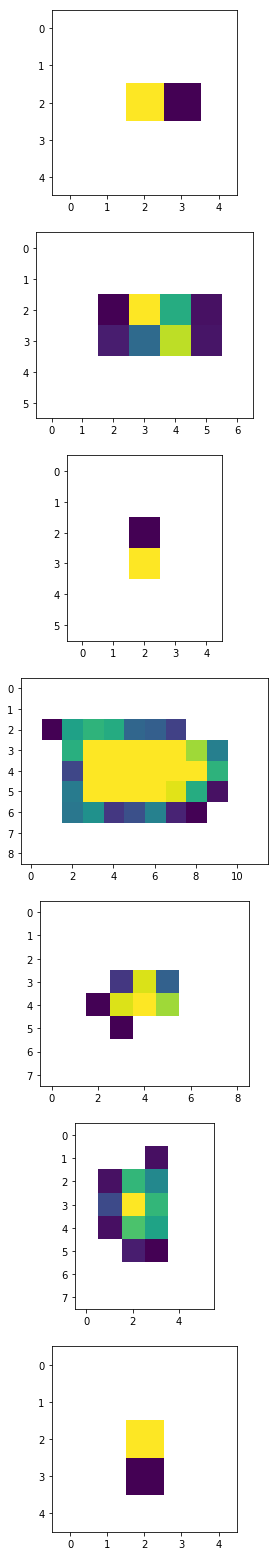

In [38]:
def getCellBoundaries(nc_file):
    boundaries=[]
    nc_data = xr.open_dataset(nc_file)
    for i in nc_data.X.values:
        for j in nc_data.Y.values:
            left=i-500 # This is based on the assumption that the grid is 1x1km
            right=i+500
            bottom=j-500
            top=j+500
            p1 = Point(left,bottom)
            p2 = Point(left,top)
            p3 = Point(right,top)
            p4 = Point(right,bottom)
            pointList = [p1, p2, p3, p4, p1]
            poly = Polygon([[p.x, p.y] for p in pointList])
            boundaries.append((poly.wkb_hex,np.nan))
    nc_data.close()
    return boundaries

#Getting averages for all stations
query = sql.SQL('''SELECT a.station_name,a.station_id
                      FROM {0}.{1} AS a
                      ;
                   '''.format(schema,
                              results + 'Shp'
                             )
                )
names= basinGenerator.run_query(query);
weightDict=dict()

boundaryTable = 'dataBoundaries'
prcColumn = 'prcIntersection'
boundaryColumn = 'boundary'
f,ax = plt.subplots(len(names),1,figsize=(5,len(names * 4)))
cnt = -1
for i in names:
    cnt += 1
    name = i[0].replace(' ','_')
    sid = i[1]
    nc_file = './DownloadedData/temperature_{}.nc'.format(name)
    boundaries = getCellBoundaries(nc_file)
    query = sql.SQL('''DROP TABLE IF EXISTS {0}.{1};
                       CREATE TABLE {0}.{1} (sid SERIAL PRIMARY KEY,
                                             {2} geometry(POLYGON,0),
                                             {3} DOUBLE PRECISION                                                   
                                             );
                    '''.format(schema,boundaryTable, boundaryColumn, prcColumn)
                   )
    basinGenerator.run_query(query,getAnswer=False);
    
    query = sql.SQL('''INSERT INTO {0}.{1} ({2},{3}) VALUES %s;
                '''.format(schema,boundaryTable, boundaryColumn, prcColumn))
    basinGenerator.run_execute_values(query,boundaries)
    
    query = sql.SQL('''ALTER TABLE {0}.{1}
                       ALTER COLUMN boundary TYPE geometry(POLYGON, 3035)
                       USING ST_SetSRID(boundary,3035);
                    '''.format(schema,boundaryTable)
               )
    basinGenerator.run_query(query,getAnswer=False)
    
    query = sql.SQL('''CREATE INDEX data_boundary_gix ON {0}.{1} USING GIST (boundary);
                '''.format(schema,boundaryTable)
           )
    basinGenerator.run_query(query,getAnswer=False)
    
    query = sql.SQL('''UPDATE {0}.{1} AS a
                        SET {2} = (ST_Area(ST_Intersection(a.{3},b.basin)))
                        FROM {0}.{4} AS b
                        WHERE b.station_id={5} AND ST_Intersects(a.{3},b.basin);
                    '''.format(schema,boundaryTable,prcColumn,boundaryColumn,results + 'Shp',sid)
                   )
    basinGenerator.run_query(query,getAnswer=False)    
    
    query = sql.SQL('''SELECT a.sid,a.{0} FROM {1}.{2} AS a;
                    '''.format(prcColumn,schema,boundaryTable)
                   )
    weights = basinGenerator.run_query(query)  
    weights = [(i[0],i[1]) for i in weights]
    idx = [i[0]-1 for i in weights] 
    weight = [i[1] for i in weights]
    
    nc_data = xr.open_dataset(nc_file)
    temp = nc_data.TG 
    dataShape = temp.shape
#     display(dataShape)

    #Getting the in a 2d array
    weightArray = np.zeros((dataShape[1:]))
    arrayIdx = np.unravel_index(idx,dataShape[2:0:-1])
    
    for i,j,k in zip(arrayIdx[1],arrayIdx[0],weight):
        weightArray[i][j] = k;
#     display(weightArray)
    ax[cnt].imshow(weightArray)
    weightDict[name] = weightArray
    
#     display(weights)

### Getting average, min and max elevation

In [34]:
query = sql.SQL('''DROP TABLE IF EXISTS oka.elev;
                   CREATE TABLE oka.elev AS (
                         SELECT station_id, (gv).x, (gv).y, (gv).val, (gv).geom AS geom
                         FROM (SELECT b.station_id,st_pixelaspolygons(a.rast) AS gv 
                               FROM norway.el As a, oka.resultsshp AS b 
                               WHERE ST_Intersects (b.basin,a.extent) 
                               ) AS foo
                         );
                ''')
basinGenerator.run_query(query,getAnswer=False)

query = sql.SQL('''CREATE INDEX elevation_boundary_gix ON oka.elev USING GIST (geom);
            '''.format(schema,boundaryTable)
       )
basinGenerator.run_query(query,getAnswer=False)

query = sql.SQL('''ALTER TABLE oka.elev ADD COLUMN pct DOUBLE PRECISION DEFAULT 0;
            '''.format(schema,boundaryTable)
       )
basinGenerator.run_query(query,getAnswer=False)


query = sql.SQL('''UPDATE oka.elev AS a
                   SET pct = (ST_Area(ST_Intersection(a.geom,b.basin)))
                        FROM oka.resultsShp AS b
                        WHERE ST_Intersects(a.geom,b.basin);;
            '''.format(schema,boundaryTable)
       )
basinGenerator.run_query(query,getAnswer=False)


query = sql.SQL('''SELECT a.station_name, 
                          ST_Area(a.basin)/10^6 AS area_km2, 
                          b.* 
                   FROM (SELECT station_id,sum(a.pct*a.val)/sum(a.pct) as mean_elev, MIN(a.val) as min_elev, MAX(a.val) as max_elev 
                         FROM oka.elev a WHERE a.pct > 0.0 GROUP BY a.station_id
                         ) AS b
                   INNER JOIN oka.resultsShp as a ON a.station_id = b.station_id;''')

topoInfo = basinGenerator.run_query(query)
topo = pd.DataFrame(topoInfo)
topo.columns = ['name','area (km2)', 'station id', 'average elevation','min elevation','max elevation']
topo = topo.set_index('name')
display(topo)


,area (km2),station id,average elevation,min elevation,max elevation
name,,,,,
Birkenes,0.435000,221,228.167119,190.449417,278.843903
Øygardsbekken,2.363750,12025,408.111969,179.901169,533.082642
Storgama v. dam,0.593125,12080,623.410088,582.426331,689.658813
Kårvatn,24.330000,12081,932.652316,216.609879,1381.962646
Dalelv,3.089375,12082,163.456262,3.143333,239.380600
Langtjern utløp,4.755625,108,589.982989,515.216064,755.138367
Svarttjernet,0.603125,42,452.444447,305.000366,725.527527


### Getting average precipitation and temperature

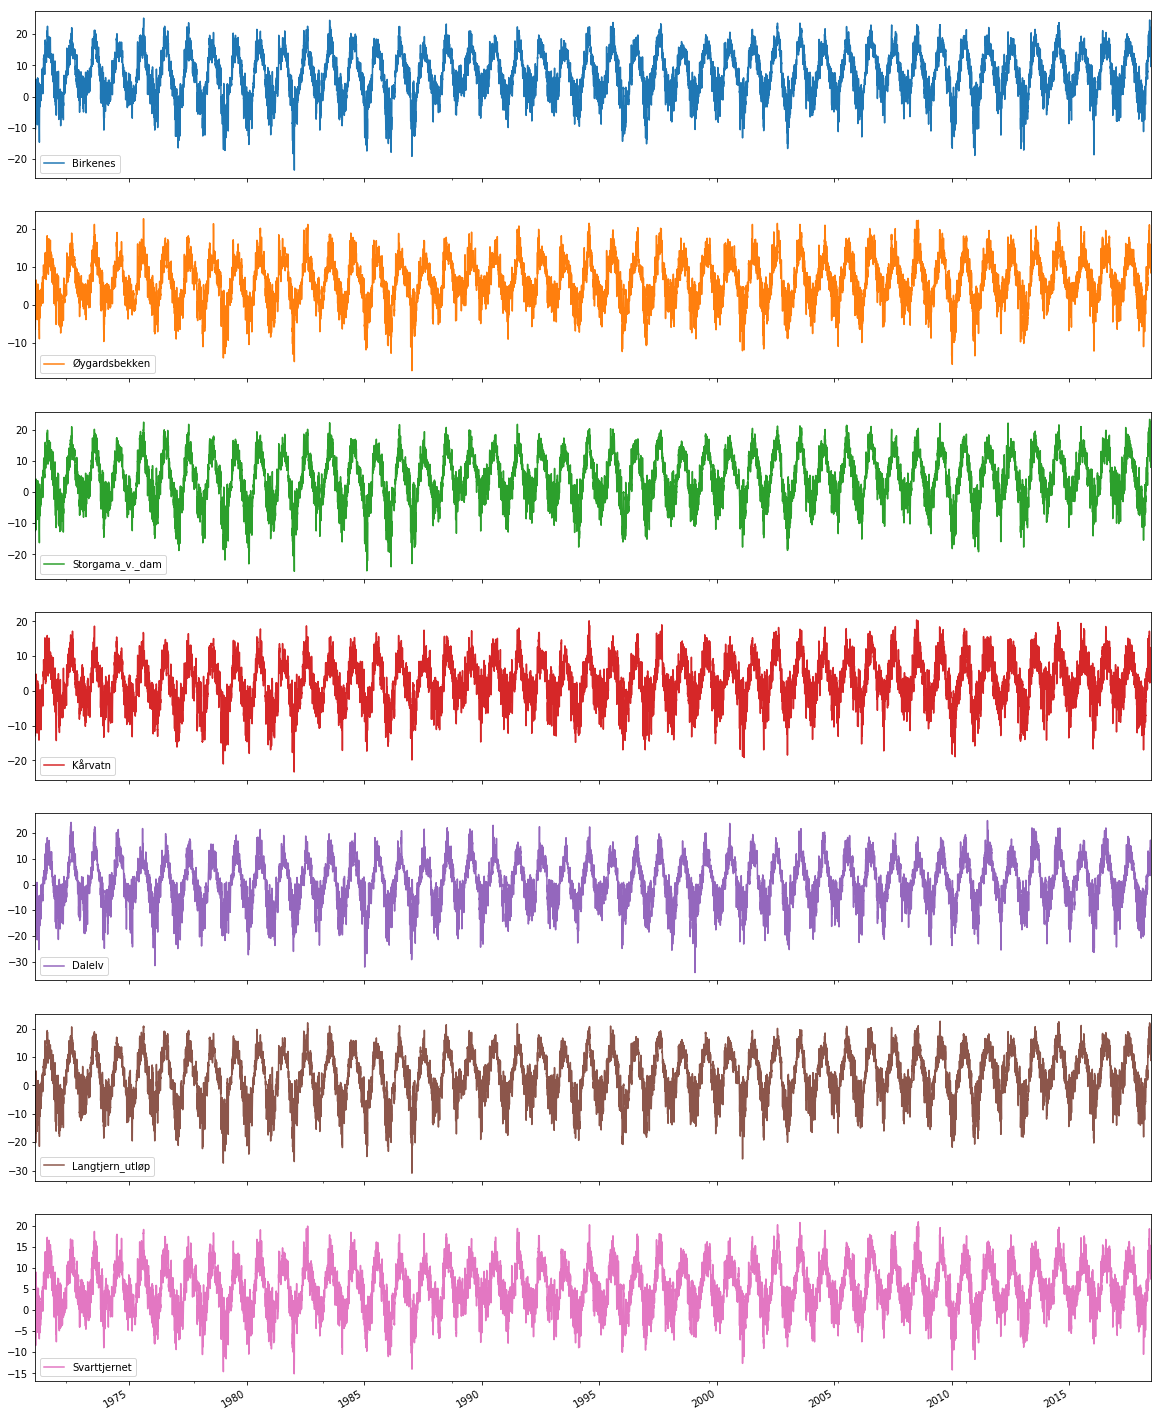

In [68]:
def getWeightedData(name,variable,weightDict,save=True):
    filename = base.format(name)
    nc_data = xr.open_dataset(filename,chunks={'time':1000})
    time = nc_data.time.values
    total_weight = np.nansum(weightDict[name])
    data = np.sum(np.sum((nc_data.variables[variable] * weightDict[name])/total_weight,axis=1),axis=1)
    nc_data.close()
    if save:
        data_df = pd.DataFrame({variable:data},index=time)
#         data_df.to_pickle('./{}_{}.pickle'.format(variable,stationName))
#         data_df.to_csv('./{}_{}.csv'.format(variable,stationName))
    return data_df


base = './DownloadedData/temperature_{}.nc'
temperature = pd.DataFrame()
for i in names:
    cnt += 1
    name = i[0].replace(' ','_')
    df = getWeightedData(name,'TG',weightDict)
    df.columns=[name]
    temperature = pd.concat([temperature, df], axis=1)
    
temperature -= 272.15
temperature.plot(subplots=True,figsize=(20,4*len(names)))
temperature.to_csv('temp.csv')

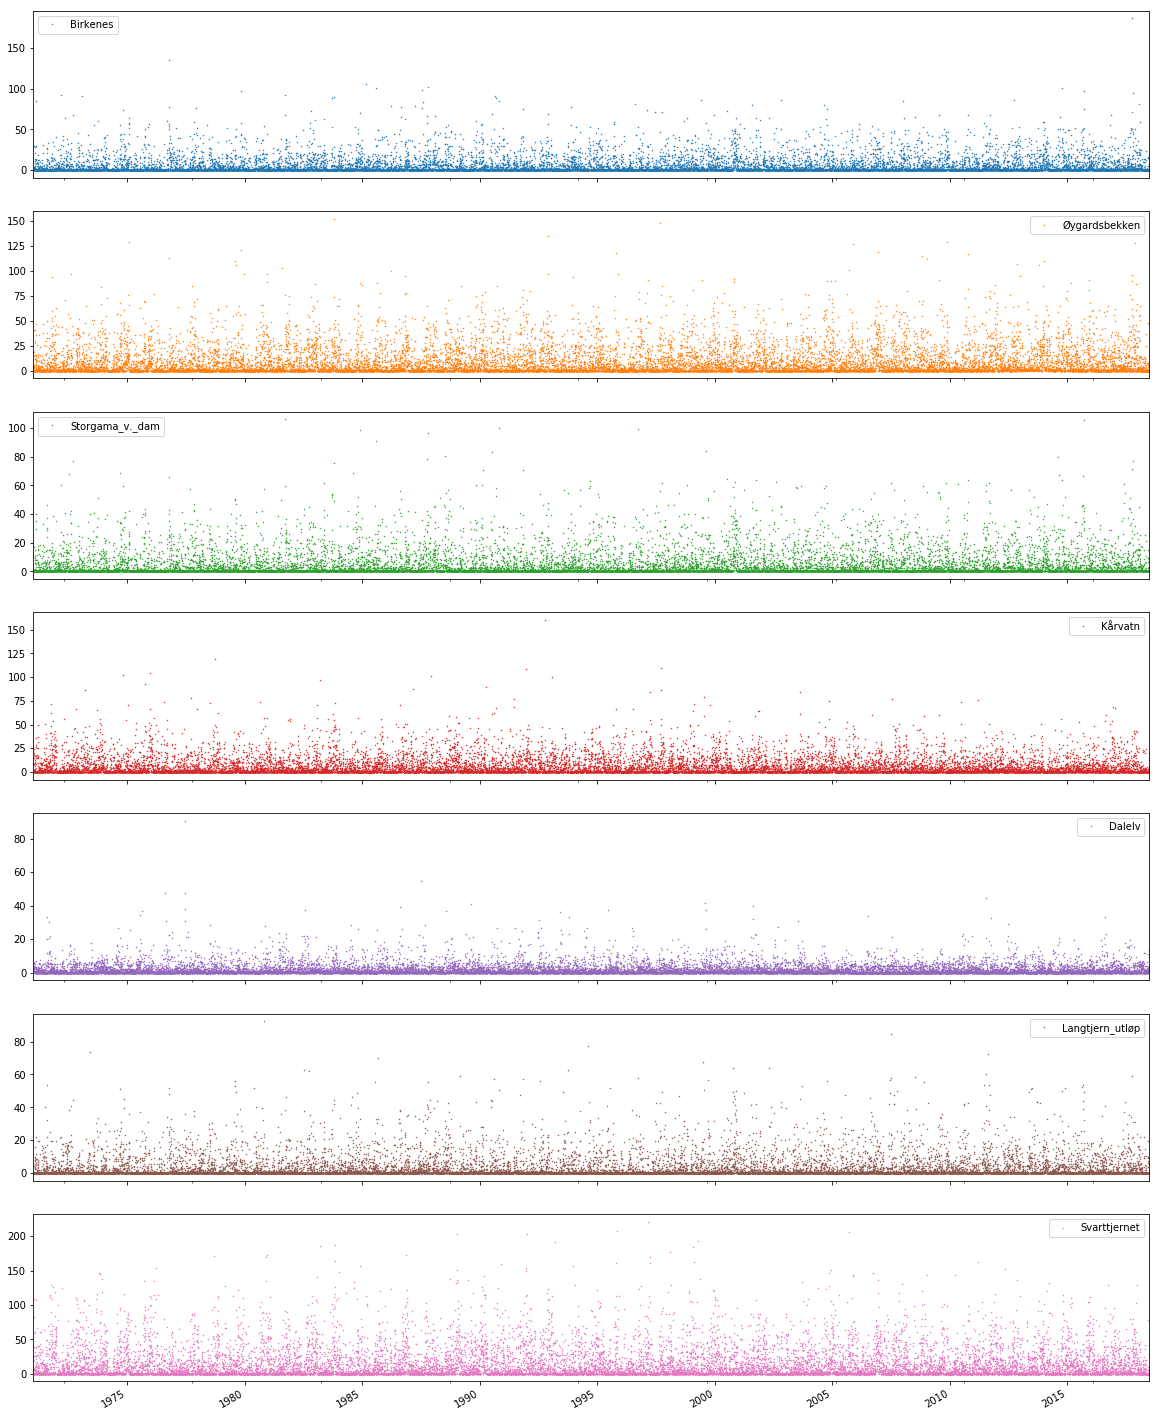

In [69]:
base = './DownloadedData/precip_{}.nc'
precipitation = pd.DataFrame()
for i in names:
    cnt += 1
    name = i[0].replace(' ','_')
    df = getWeightedData(name,'RR',weightDict)
    df.columns=[name]
    precipitation = pd.concat([precipitation, df], axis=1)
    
precipitation.plot(subplots=True,figsize=(20,4*len(names)),linestyle='None',marker='.',markersize=1)
precipitation.to_csv('precip.csv')